# From AIPC to the Cloud

Extracted from Pytorch example https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## 1. Installation of libraries

In [1]:
!pip install matplotlib

## 2. Import libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

## 3. Load and prepare data sets for AIPC and Cloud examples

In [17]:
### For Cloud we will use the entire Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset_Cloud = torchvision.datasets.CIFAR10(root='./data_cloud', train=True,
                                        download=True, transform=transform)
trainloader_Cloud = torch.utils.data.DataLoader(trainset_Cloud, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_cloud = torchvision.datasets.CIFAR10(root='./data_cloud', train=False,
                                       download=True, transform=transform)
testloader_cloud = torch.utils.data.DataLoader(testset_cloud, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:19<00:00, 8847786.59it/s]


Extracting ./data_cloud/cifar-10-python.tar.gz to ./data_cloud
Files already downloaded and verified


In [24]:
## For AI PC we will use a portion of the initial dataset

from sklearn.model_selection import train_test_split

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Initialize the CIFAR-10 dataset and download it
full_dataset = torchvision.datasets.CIFAR10(root='./data_ai_pc', train=True,
                                             download=True, transform=transform)

# Size of the first subset
train_size_AI_PC = 20000  

# Get the labels for each sample in the full dataset
labels = torch.tensor(full_dataset.targets)

# Use stratified sampling to split the dataset into train and test sets
train_indices, test_indices = train_test_split(range(len(full_dataset)), train_size=train_size_AI_PC,test_size=2000,
                                               stratify=labels, random_state=42)

# Create the train and test subsets using the selected indices
trainset_AI_PC = torch.utils.data.Subset(full_dataset, train_indices)
testset_AI_PC = torch.utils.data.Subset(full_dataset, test_indices)

# Create the dataloaders
batch_size = 4
trainloader_AI_PC = torch.utils.data.DataLoader(trainset_AI_PC, batch_size=batch_size, shuffle=True)
testloader_AI_PC = torch.utils.data.DataLoader(testset_AI_PC, batch_size=batch_size, shuffle=False)

# Print the number of samples in each subset
print("Number of samples in trainset_AI_PC:", len(trainset_AI_PC))
print("Number of samples in testset_AI_PC:", len(testset_AI_PC))

100%|██████████| 170498071/170498071 [00:19<00:00, 8641735.19it/s] 


Extracting ./data_ai_pc/cifar-10-python.tar.gz to ./data_ai_pc
Number of samples in trainset_AI_PC: 20000
Number of samples in testset_AI_PC: 2000


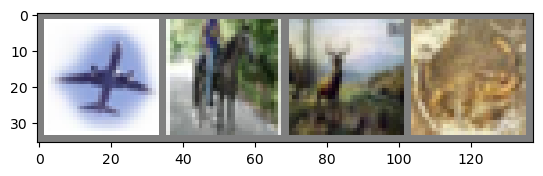

plane horse deer  frog 


In [19]:
# Display dataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_AI_PC)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 3. Define Neural Network and optimizer

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



## 4. Training

## 4.1 Training for AI PC

### 4.2 Train using stock Pytorch

In [21]:
import torch.optim as optim
model_stock = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_stock.parameters(), lr=0.001, momentum=0.9)

In [25]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_AI_PC, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_stock(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 699:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   700] loss: 0.573
[1,  1400] loss: 0.581
[1,  2100] loss: 0.570
[1,  2800] loss: 0.568
[1,  3500] loss: 0.557
[1,  4200] loss: 0.534
[1,  4900] loss: 0.532
[2,   700] loss: 0.518
[2,  1400] loss: 0.513
[2,  2100] loss: 0.514
[2,  2800] loss: 0.503
[2,  3500] loss: 0.497
[2,  4200] loss: 0.492
[2,  4900] loss: 0.496
Finished Training


### 4.1.2 Train using IPEX

In [ ]:
import intel_extension_for_pytorch as ipex
model_ipex = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ipex.parameters(), lr=0.001, momentum=0.9)

# Invoke optimize function against the model object and optimizer object
model_ipex, optimizer = ipex.optimize(model_ipex, optimizer, dtype=torch.float32)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_AI_PC, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_ipex(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 699:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

## 4.2 Training in the cloud

### 4.2.1 Train using stock Pytorch

In [ ]:
import torch.optim as optim
model_stock = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_stock.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_Cloud, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_stock(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 699:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

### 4.2.2 Train using IPEX

## 5. Test performance

## 5.1 Test on AIPC

### 5.1.2 Test on AIPC (Stock Pytorch)

In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_AI_PC:
        images, labels = data
        outputs = model_stock(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.0 %
Accuracy for class: car   is 61.5 %
Accuracy for class: bird  is 8.0 %
Accuracy for class: cat   is 26.0 %
Accuracy for class: deer  is 43.5 %
Accuracy for class: dog   is 23.0 %
Accuracy for class: frog  is 39.0 %
Accuracy for class: horse is 34.5 %
Accuracy for class: ship  is 63.5 %
Accuracy for class: truck is 29.0 %


### 5.1.2 Test on AIPC (IPEX)

## 5.2 Test on Cloud

## APPENDIX : CONSIDERATIONS

Training a model with a limited amount of data is a pragmatic approach, especially if you're in the early stages of model development or data collection. It allows you to quickly iterate and experiment with different model architectures, hyperparameters, and feature engineering techniques to identify what works best for your problem domain.

Once you have a good understanding of what works and what doesn't, scaling up to a larger dataset can indeed be beneficial. More data often leads to better generalization and performance, as it helps the model learn more robust patterns and relationships within the data.

However, there are a few considerations to keep in mind:

- **Quality of Data**: Ensure that your limited dataset is representative of the broader population or distribution you're targeting. Biases or outliers in the limited dataset can skew the model's understanding and lead to poor generalization when scaling up.

- **Overfitting**: With a limited dataset, there's a risk of overfitting—where the model learns to memorize the training data rather than generalize to unseen examples. Regularization techniques and validation strategies should be employed to mitigate this risk.

- **Transferability**: Ideally, the insights gained from training on the limited dataset should transfer well to the larger dataset. However, there may be domain shifts or differences in data distribution between the two datasets, requiring careful adaptation and fine-tuning of the model.
- **Computational Resources**: Training with a larger dataset typically requires more computational resources in terms of processing power, memory, and time. Ensure you have the necessary infrastructure to handle the increased scale.

In summary, starting with a limited dataset for initial experimentation is a great approach, but it's essential to validate the model's performance on a larger dataset to ensure robustness and generalization. Additionally, continuous monitoring and refinement may be necessary as you scale up to address any new challenges or nuances introduced by the larger dataset.